In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam, Adamax, Ftrl

2024-06-16 09:05:31.601831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 09:05:31.601928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 09:05:31.726123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel('/kaggle/input/btc-data/btc_processed_data.xlsx')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
test_size,train_size

(576, 1343)

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1 + 1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)

combined_data = np.concatenate((train_data[-time_step:], test_data))
X_test, ytest = create_dataset(combined_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", ytest.shape)

x_train shape: (1243, 100, 1)
y_train shape: (1243,)
x_test shape: (576, 100, 1)
y_test shape: (576,)


In [10]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Print model summary (optional)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0655 - val_loss: 0.0031
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [14]:
# EVALUATION
from sklearn.metrics import mean_squared_error, mean_absolute_error


test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

test_mse = mean_squared_error(ytest, y_pred)

test_mae = mean_absolute_error(ytest, y_pred)

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Testing RMSE: {test_rmse}")
print(f"Testing MSE: {test_mse}")
print(f"Testing MAE: {test_mae}")
print(f"Testing MAPE: {test_mape}%")

Testing RMSE: 38356.269750349056
Testing MSE: 1471203429.161542
Testing MAE: 35090.04588096897
Testing MAPE: 9573120.851617994%


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if(len(temp_input) > 100):
        # Ensure only the last 100 elements are used
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # Predict the next value
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        # Remove the first element to maintain the size of 100
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1

# print(lst_output)

[0.8994506]
101
1 day input [0.67756889 0.68967404 0.69201294 0.73224787 0.76921984 0.84739737
 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461 0.86609866
 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915 0.98615743
 0.97688739 1.         0.97566562 0.9469183  0.88793761 0.93230318
 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499 0.86986376
 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542 0.95397313
 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056 0.93400854
 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905 0.96399961
 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929 0.8662525
 0.82968151 0.86193771 0.86670989 0.88331172 0.88233372 0.90990125
 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873  0.85617441
 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184 0.8674009
 0.86941556 0.8568772  0.84494544 0.82840125 0.85526172 0.82270083
 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604 0.88673257
 0.91299111 0.91138888 0.90183292 0.

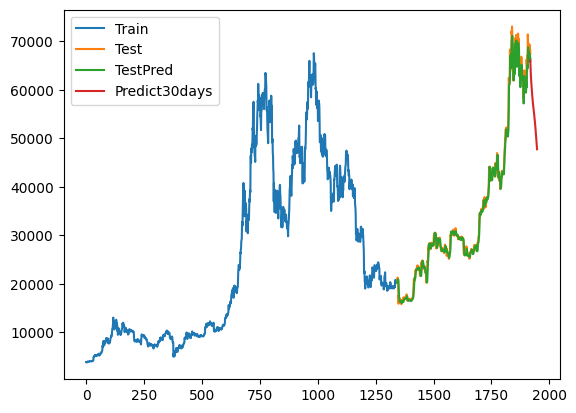

In [16]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict30days'])
plt.show()

<h2> 60 days

In [17]:
# 14. Dự báo 60 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.8994506]
101
1 day input [0.67756889 0.68967404 0.69201294 0.73224787 0.76921984 0.84739737
 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461 0.86609866
 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915 0.98615743
 0.97688739 1.         0.97566562 0.9469183  0.88793761 0.93230318
 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499 0.86986376
 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542 0.95397313
 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056 0.93400854
 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905 0.96399961
 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929 0.8662525
 0.82968151 0.86193771 0.86670989 0.88331172 0.88233372 0.90990125
 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873  0.85617441
 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184 0.8674009
 0.86941556 0.8568772  0.84494544 0.82840125 0.85526172 0.82270083
 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604 0.88673257
 0.91299111 0.91138888 0.90183292 0.

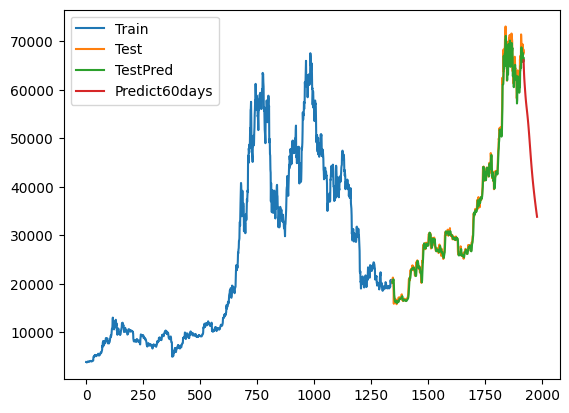

In [18]:
# 15.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict60days'])
plt.show()

<h2> 90 days

In [19]:
# 16. Dự báo 90 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.8994506]
101
1 day input [0.67756889 0.68967404 0.69201294 0.73224787 0.76921984 0.84739737
 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461 0.86609866
 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915 0.98615743
 0.97688739 1.         0.97566562 0.9469183  0.88793761 0.93230318
 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499 0.86986376
 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542 0.95397313
 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056 0.93400854
 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905 0.96399961
 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929 0.8662525
 0.82968151 0.86193771 0.86670989 0.88331172 0.88233372 0.90990125
 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873  0.85617441
 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184 0.8674009
 0.86941556 0.8568772  0.84494544 0.82840125 0.85526172 0.82270083
 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604 0.88673257
 0.91299111 0.91138888 0.90183292 0.

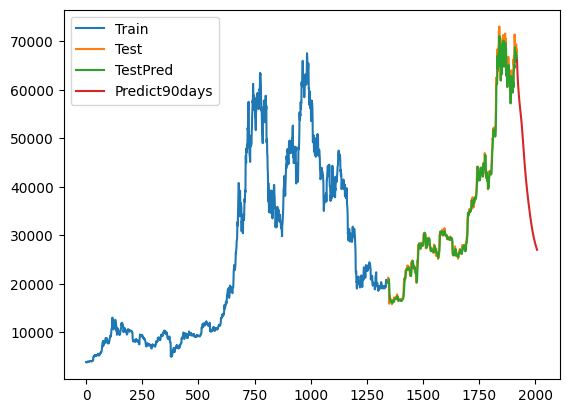

In [20]:
# 17.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict90days'])
plt.show()